In [2]:
import os
from langchain.document_loaders import TextLoader

In [3]:
SAVE_DIRECTORY = "./raw_docs"

In [ ]:
file_paths = [os.path.join(SAVE_DIRECTORY, file) for file in os.listdir(SAVE_DIRECTORY)]

# Load all documents from the folder
documents = []
for file_path in file_paths:
    loader = TextLoader(file_path)
    documents.extend(loader.load())


In [5]:
documents

[Document(metadata={'source': './raw_docs\\app-service-and-cloud-services.md'}, page_content='# App and Cloud Services\n\nA Service could be a Kubernetes Deployment, Stateful set or a Daemon set. It can also be a Lambda function or an ECS task or service. It essentially captures a microservice. Each service (except Lambda) can be given a load balancer to expose itself and be assigned a DNS name.\n\n{% hint style="info" %}\nDuploCloud Service should not be confused with a Kubernetes or a ECS service. By service we mean application components that can either be Docker-based or serverless.\n{% endhint %}\n\nBelow is an image of some properties of a service:\n\n<figure><img src="../../.gitbook/assets/screenshot-nimbusweb.me-2024.02.20-15_45_12.png" alt=""><figcaption></figcaption></figure>\n\n**Cloud Services:** DuploCloud supports a simple application specific interface to configure dozens of cloud services like S3, SNS, SQS, Kafka, Elasticsearch, Data Pipeline, EMR, Sagemaker, Azure Redi

In [18]:
from langchain.text_splitter import CharacterTextSplitter

# Step 2: Split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)
print(len(texts))
texts


Created a chunk of size 744, which is longer than the specified 500
Created a chunk of size 586, which is longer than the specified 500
Created a chunk of size 564, which is longer than the specified 500
Created a chunk of size 546, which is longer than the specified 500


20


[Document(metadata={'source': './raw_docs\\app-service-and-cloud-services.md'}, page_content='# App and Cloud Services\n\nA Service could be a Kubernetes Deployment, Stateful set or a Daemon set. It can also be a Lambda function or an ECS task or service. It essentially captures a microservice. Each service (except Lambda) can be given a load balancer to expose itself and be assigned a DNS name.'),
 Document(metadata={'source': './raw_docs\\app-service-and-cloud-services.md'}, page_content='{% hint style="info" %}\nDuploCloud Service should not be confused with a Kubernetes or a ECS service. By service we mean application components that can either be Docker-based or serverless.\n{% endhint %}\n\nBelow is an image of some properties of a service:\n\n<figure><img src="../../.gitbook/assets/screenshot-nimbusweb.me-2024.02.20-15_45_12.png" alt=""><figcaption></figcaption></figure>'),
 Document(metadata={'source': './raw_docs\\app-service-and-cloud-services.md'}, page_content='**Cloud Serv

In [44]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# load half the embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vectorstore = FAISS.from_documents(texts, embeddings)


In [28]:
# from langchain_community.embeddings import Model2vecEmbeddings

# embeddings = Model2vecEmbeddings("minishlab/potion-base-8M")
# vectorstore = FAISS.from_documents(texts, embeddings)

In [ ]:
# from langchain.embeddings import HuggingFaceEmbeddings

# embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# vectorstore = FAISS.from_documents(texts, embedding_model)

In [40]:
from langchain.llms import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain

llm = OpenAI(temperature=0)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Use three sentence maximum and keep the answer concise. "
    "Context: {context}\n"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
chain = create_retrieval_chain(retriever, question_answer_chain)

chain.invoke({"input": "Does Duplocloud generate terraform behind the scenes?"})


{'input': 'Does Duplocloud generate terraform behind the scenes?',
 'context': [Document(id='a67801a9-53a1-48bd-8b9c-b098827eb052', metadata={'source': './raw_docs\\app-service-and-cloud-services.md'}, page_content='{% hint style="info" %}\nDuploCloud Service should not be confused with a Kubernetes or a ECS service. By service we mean application components that can either be Docker-based or serverless.\n{% endhint %}\n\nBelow is an image of some properties of a service:\n\n<figure><img src="../../.gitbook/assets/screenshot-nimbusweb.me-2024.02.20-15_45_12.png" alt=""><figcaption></figcaption></figure>')],
 'answer': '\n\nNo, DuploCloud does not generate terraform behind the scenes. It is a service that manages application components, such as Docker-based or serverless components.'}

In [49]:
from langchain.agents import initialize_agent, Tool, AgentType
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI

# Set up OpenAI and SerpAPI API keys

# Create the Web Search Tool using SerpAPI
search_tool = DuckDuckGoSearchResults()

# Initialize the Document Store (Example using FAISS)
embedding = OpenAIEmbeddings()
document_store = FAISS.load_local(
    "./data/stores/faiss_vector_store", embeddings, allow_dangerous_deserialization=True
)
# Create the Retrieval-Augmented Generation (RAG) tool
rag_tool = Tool(
    name="Document Retrieval",
    func=lambda query: document_store.similarity_search(query),
    description="This tool retrieves documents from a local document store."
)

# Combine the tools into an agent
tools = [search_tool, rag_tool]

# Set up the LLM for your chain
llm = ChatOpenAI(temperature=0)

# Define an agent to handle the conversation
agent = initialize_agent(
    tools=tools,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    llm=llm,
    verbose=True
)

# Example interaction
def answer_query(query):
    response = agent.run(query)
    return response

# Example of usage
query = "What is the latest news on AI in 2025?"
response = answer_query(query)
print(response)




> Entering new AgentExecutor chain...
I should use the Duck Duck Go search tool to find the latest news on AI in 2025.
Action: duckduckgo_results_json
Action Input: AI news 2025
Observation: snippet: If 2023 was the year of AI fervor, following the late-2022 release of ChatGPT, 2024 was marked by a steady drumbeat of advances as systems got smarter, faster, and cheaper to run. AI also began to ..., title: 5 Predictions for AI in 2025 - TIME, link: https://time.com/7204665/ai-predictions-2025/, snippet: Based on the insights gleaned from this handful of AI experts, 2025 looks to be even more revolutionary for the sector than 2024 with some surprising predictions and trends likely to develop ..., title: Top 5 AI Predictions From Experts In 2025 - Forbes, link: https://www.forbes.com/sites/torconstantino/2024/12/31/top-5-ai-predictions-from-experts-in-2025/, snippet: Bonus Trend: Smarter, Faster AI Applications. By 2025, AI systems will be smarter, faster, and more efficient, thanks to 

In [276]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field


class State(TypedDict):
    rag_documents: list[str]
    chat_response: str
    chat_history: list[str]
    query: str
    web_sources: list[str]
    document_search: bool




graph_builder = StateGraph(State)

In [277]:

def determine_document_search(state: State):
    print("NODE: determine_document_search")
    query = state["query"]
    response = chain.invoke({"input": f"Does this query reference to DuploCloud or a question about DuploCloud? query:{query}"})

    print(response["answer"])
    state["document_search"] = True
    state["chat_response"] = response["answer"]

    return state

def llm_rag(state: State):
    print("NODE: llm_rag")
    query = state["query"]
    print(query)
    response = chain.invoke({"input": query})
    print(response["answer"])
    print(type(response["answer"]))

    state["rag_documents"] = ["doc1", "doc2", "doc3"]
    state["chat_response"] = response["answer"]

    print(state)

    return state

def llm_web(state: State):
    print("NODE: llm_web")
    query = state["query"]
    print(query)
    response = chain.invoke({"input": query})
    state["chat_response"] = response["answer"]

    return state


graph_builder.add_node("determine_document_search", determine_document_search)
graph_builder.add_node("llm_rag", llm_rag)
graph_builder.add_node("llm_web", llm_web)

In [278]:
def route_document_search(
    state: State,
):
    print("CONDITIONAL EDGE: route_document_search")
    
    if state["document_search"]:
        print("llm_rag chosen")
        return "llm_rag"
    else:
        print("llm_web chosen")
        return "llm_web"

graph_builder.add_conditional_edges(
    "determine_document_search",
    route_document_search,
    {"llm_rag": "llm_rag", "llm_web": "llm_web"},
)


In [279]:
graph_builder.add_edge(START, "determine_document_search")
graph_builder.add_edge("llm_rag", END)
graph_builder.add_edge("llm_web", END)
graph = graph_builder.compile()

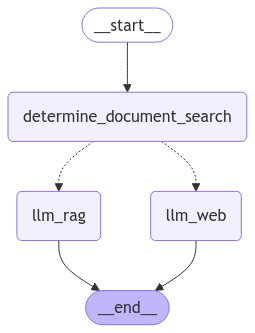

In [283]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    graph.get_graph().draw_mermaid_png(output_file_path="./assistant/graph.png")
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [281]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"query": user_input}):
        for value in event.values():
            print("Assistant:", value)


In [282]:
response = graph.invoke({"query": "What is duplocloud?"})
print(response)
response

NODE: determine_document_search


This query is about DuploCloud, specifically about its properties as shown in the image.
CONDITIONAL EDGE: route_document_search
llm_rag chosen
NODE: llm_rag
What is duplocloud?


DuploCloud is an application component that can either be Docker-based or serverless. It should not be confused with a Kubernetes or ECS service.
<class 'str'>
{'chat_response': '\n\nDuploCloud is an application component that can either be Docker-based or serverless. It should not be confused with a Kubernetes or ECS service.', 'query': 'What is duplocloud?', 'document_search': True, 'rag_documents': ['doc1', 'doc2', 'doc3']}
{'rag_documents': ['doc1', 'doc2', 'doc3'], 'chat_response': '\n\nDuploCloud is an application component that can either be Docker-based or serverless. It should not be confused with a Kubernetes or ECS service.', 'query': 'What is duplocloud?', 'document_search': True}


{'rag_documents': ['doc1', 'doc2', 'doc3'],
 'chat_response': '\n\nDuploCloud is an application component that can either be Docker-based or serverless. It should not be confused with a Kubernetes or ECS service.',
 'query': 'What is duplocloud?',
 'document_search': True}